<a href="https://colab.research.google.com/github/IGPTsewwandi/Image-Processing-Based-Smart-Waste-Management-System-/blob/feature%2Fpreprocess/Smart_Waste_Management_System_train_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Train ML models using feature.csv

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [07:44:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



🔎 Model Performance Comparison:

                 Model  Accuracy  Precision    Recall  F1 Score
5              XGBoost  0.604270   0.601088  0.604270  0.600107
2        Random Forest  0.601291   0.600465  0.601291  0.596299
4    Gradient Boosting  0.581927   0.584816  0.581927  0.575899
1            SVM (RBF)  0.544191   0.551273  0.544191  0.542046
3                  kNN  0.542205   0.545022  0.542205  0.541652
0  Logistic Regression  0.508441   0.520450  0.508441  0.500257

🏆 Best model selected: XGBoost


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [07:44:32] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



📑 Classification Report:

              precision    recall  f1-score   support

       Glass       0.57      0.55      0.56       406
       Metal       0.57      0.45      0.50       394
     Organic       0.60      0.65      0.62       399
       Paper       0.62      0.60      0.61       408
     Plastic       0.65      0.77      0.70       407

    accuracy                           0.60      2014
   macro avg       0.60      0.60      0.60      2014
weighted avg       0.60      0.60      0.60      2014



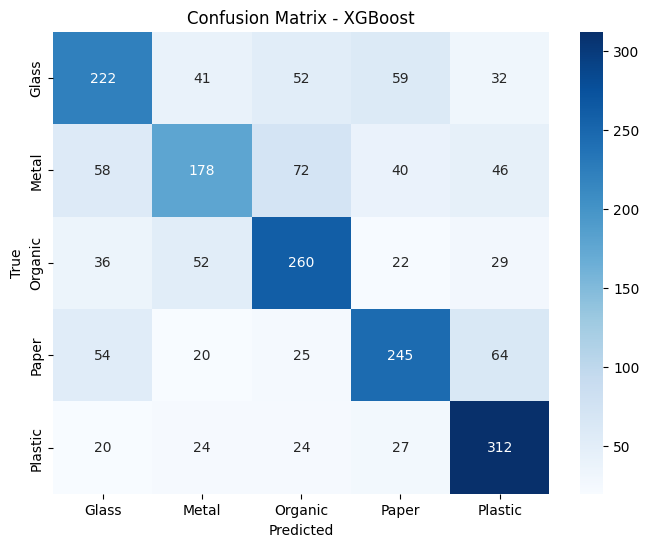


✅ Best model saved at: /content/drive/MyDrive/Smart Waste Management System/ML/best_model.pkl


In [ ]:
# Install xgboost if not already
!pip install xgboost -q

# Install xgboost if not already
!pip install xgboost -q

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Load dataset
csv_path = "/content/drive/MyDrive/Smart Waste Management System/Dataset_Split/Train/features.csv"
df = pd.read_csv(csv_path)

# Features (all f0...f108)
X = df.drop(columns=["filename", "class"])
y = df["class"]

# Encode class labels into numbers
label_enc = LabelEncoder()
y_encoded = label_enc.fit_transform(y)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVM (RBF)": SVC(kernel="rbf", probability=True),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "kNN": KNeighborsClassifier(n_neighbors=5),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric="mlogloss", random_state=42)
}

# Train & evaluate all models
results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average="weighted", zero_division=0)
    rec = recall_score(y_test, y_pred, average="weighted", zero_division=0)
    f1 = f1_score(y_test, y_pred, average="weighted", zero_division=0)
    results.append([name, acc, prec, rec, f1])

# Show results table
results_df = pd.DataFrame(results, columns=["Model", "Accuracy", "Precision", "Recall", "F1 Score"])
print("\n🔎 Model Performance Comparison:\n")
print(results_df.sort_values(by="Accuracy", ascending=False))

# Pick best model automatically
best_model_name = results_df.sort_values(by="Accuracy", ascending=False).iloc[0]["Model"]
print(f"\n🏆 Best model selected: {best_model_name}")

best_model = models[best_model_name]
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

# Classification Report
print("\n📑 Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=label_enc.classes_))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_enc.classes_,
            yticklabels=label_enc.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Confusion Matrix - {best_model_name}")
plt.show()

# Save best model
model_path = "/content/drive/MyDrive/Smart Waste Management System/ML/best_model.pkl"
joblib.dump(best_model, model_path)
print(f"\n✅ Best model saved at: {model_path}")



# **Load Saved Model**

In [ ]:
import joblib
import cv2
import numpy as np
import os
from glob import glob
from skimage.feature import local_binary_pattern
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Paths
model_path = "/content/drive/MyDrive/Smart Waste Management System/ML/best_model.pkl"
validation_dir = "/content/drive/MyDrive/Smart Waste Management System/Dataset_Split/Validation"
test_dir = "/content/drive/MyDrive/Smart Waste Management System/Dataset_Split/Test"

# Load model
best_model = joblib.load(model_path)
print("✅ Model loaded.")


✅ Model loaded.


# **Prepare Label Encoder & Scaler**

In [ ]:
import pandas as pd

# Load training CSV to get scaler and label encoder info
train_csv = "/content/drive/MyDrive/Smart Waste Management System/Dataset_Split/Train/features.csv"
df_train = pd.read_csv(train_csv)

X_train_csv = df_train.drop(columns=["filename","class"])
y_train_csv = df_train["class"]

# Label encoder
label_enc = LabelEncoder()
label_enc.fit(y_train_csv)

# Scaler
scaler = StandardScaler()
scaler.fit(X_train_csv)


StandardScaler()

# **Feature Extraction Function (Same as Training)**

In [ ]:
def extract_features(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Color histogram
    hist_b = cv2.calcHist([img], [0], None, [32], [0,256]).flatten()
    hist_g = cv2.calcHist([img], [1], None, [32], [0,256]).flatten()
    hist_r = cv2.calcHist([img], [2], None, [32], [0,256]).flatten()
    color_hist = np.concatenate([hist_b, hist_g, hist_r])

    # Shape features
    contours, _ = cv2.findContours(gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        largest = max(contours, key=cv2.contourArea)
        area = cv2.contourArea(largest)
        perimeter = cv2.arcLength(largest, True)
        x, y, w, h = cv2.boundingRect(largest)
        aspect_ratio = w/h if h!=0 else 0
    else:
        area, perimeter, aspect_ratio = 0,0,0

    # LBP
    lbp = local_binary_pattern(gray, P=8, R=1, method="uniform")
    lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0,10), range=(0,9))
    lbp_hist = lbp_hist.astype("float")
    lbp_hist /= (lbp_hist.sum() + 1e-6)

    # Edge density
    edges = cv2.Canny(gray,100,200)
    edge_density = np.sum(edges>0)/edges.size

    # Combine all features
    features = np.concatenate([color_hist, [area, perimeter, aspect_ratio], lbp_hist, [edge_density]])
    return features


# **Load Images and Extract Features**

In [ ]:
def load_dataset_features(folder):
    X_list = []
    y_list = []
    classes = [d for d in os.listdir(folder) if os.path.isdir(os.path.join(folder,d))]

    for cls in classes:
        cls_path = os.path.join(folder, cls)
        img_files = []
        for ext in ["*.jpg","*.jpeg","*.png"]:
            img_files.extend(glob(os.path.join(cls_path, ext)))
        for img_file in img_files:
            img = cv2.imread(img_file)
            if img is None:
                continue
            features = extract_features(img)
            X_list.append(features)
            y_list.append(cls)
    return np.array(X_list), np.array(y_list)

# Validation features
X_val, y_val = load_dataset_features(validation_dir)
y_val_encoded = label_enc.transform(y_val)
X_val_scaled = scaler.transform(X_val)

# Test features
X_test, y_test = load_dataset_features(test_dir)
y_test_encoded = label_enc.transform(y_test)
X_test_scaled = scaler.transform(X_test)


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


# **Evaluate on Validation & Test Sets**


📑 Validation Report:

              precision    recall  f1-score   support

       Glass       0.65      0.67      0.66       331
       Metal       0.43      0.25      0.32       187
     Organic       0.56      0.52      0.54       221
       Paper       0.62      0.61      0.62       437
     Plastic       0.66      0.81      0.72       380

    accuracy                           0.62      1556
   macro avg       0.58      0.57      0.57      1556
weighted avg       0.60      0.62      0.61      1556



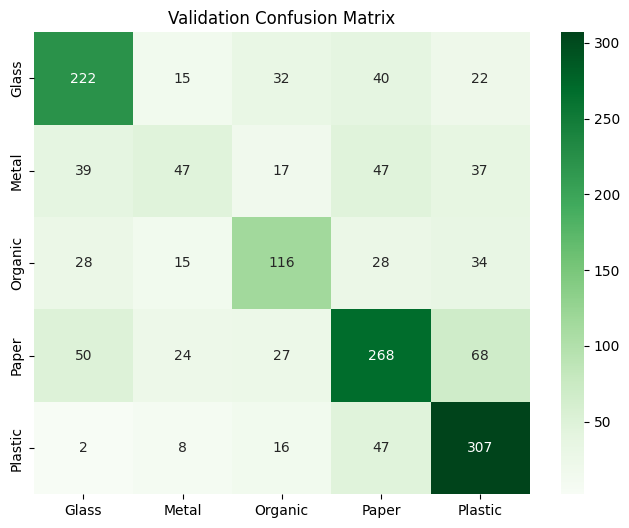


📑 Test Report:

              precision    recall  f1-score   support

       Glass       0.65      0.59      0.62       333
       Metal       0.38      0.27      0.32       189
     Organic       0.62      0.60      0.61       222
       Paper       0.63      0.68      0.65       439
     Plastic       0.70      0.81      0.75       382

    accuracy                           0.63      1565
   macro avg       0.60      0.59      0.59      1565
weighted avg       0.62      0.63      0.62      1565



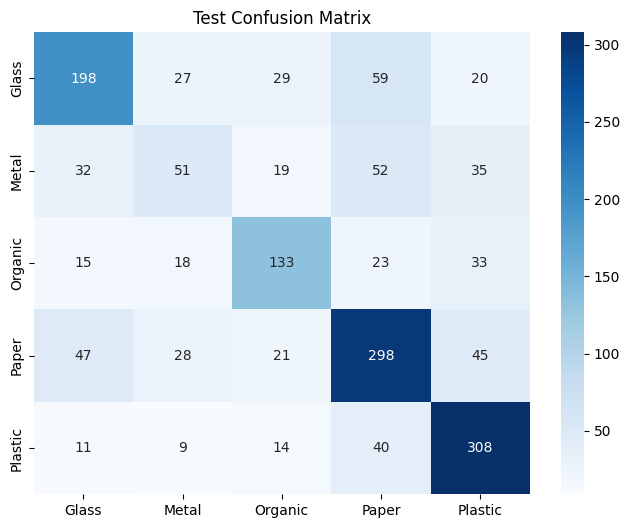

In [ ]:
# Validation
y_val_pred = best_model.predict(X_val_scaled)
print("\n📑 Validation Report:\n")
print(classification_report(y_val_encoded, y_val_pred, target_names=label_enc.classes_))

cm_val = confusion_matrix(y_val_encoded, y_val_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm_val, annot=True, fmt="d", cmap="Greens",
            xticklabels=label_enc.classes_,
            yticklabels=label_enc.classes_)
plt.title("Validation Confusion Matrix")
plt.show()

# Test
y_test_pred = best_model.predict(X_test_scaled)
print("\n📑 Test Report:\n")
print(classification_report(y_test_encoded, y_test_pred, target_names=label_enc.classes_))

cm_test = confusion_matrix(y_test_encoded, y_test_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_enc.classes_,
            yticklabels=label_enc.classes_)
plt.title("Test Confusion Matrix")
plt.show()


In [ ]:
import pandas as pd
import cv2
import numpy as np
import joblib
from sklearn.preprocessing import LabelEncoder, StandardScaler
from skimage.feature import local_binary_pattern

# Load saved model
best_model = joblib.load("/content/drive/MyDrive/Smart Waste Management System/ML/best_model.pkl")

# Recreate scaler and label encoder from training CSV
train_csv = "/content/drive/MyDrive/Smart Waste Management System/Dataset_Split/Train/features.csv"
df_train = pd.read_csv(train_csv)

X_train_csv = df_train.drop(columns=["filename","class"])
y_train_csv = df_train["class"]

# Label encoder
label_enc = LabelEncoder()
label_enc.fit(y_train_csv)

# Scaler
scaler = StandardScaler()
scaler.fit(X_train_csv)

# Feature extraction function (same as training)
def extract_features(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Color histogram
    hist_b = cv2.calcHist([img], [0], None, [32], [0,256]).flatten()
    hist_g = cv2.calcHist([img], [1], None, [32], [0,256]).flatten()
    hist_r = cv2.calcHist([img], [2], None, [32], [0,256]).flatten()
    color_hist = np.concatenate([hist_b, hist_g, hist_r])

    # Shape features
    contours, _ = cv2.findContours(gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        largest = max(contours, key=cv2.contourArea)
        area = cv2.contourArea(largest)
        perimeter = cv2.arcLength(largest, True)
        x, y, w, h = cv2.boundingRect(largest)
        aspect_ratio = w/h if h !=0 else 0
    else:
        area, perimeter, aspect_ratio = 0,0,0

    # LBP texture
    lbp = local_binary_pattern(gray, P=8, R=1, method="uniform")
    lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0,10), range=(0,9))
    lbp_hist = lbp_hist.astype("float")
    lbp_hist /= (lbp_hist.sum()+1e-6)

    # Edge density
    edges = cv2.Canny(gray,100,200)
    edge_density = np.sum(edges>0)/edges.size

    return np.concatenate([color_hist,[area,perimeter,aspect_ratio],lbp_hist,[edge_density]])

# Input image path
img_path = "/content/drive/MyDrive/Smart Waste Management System/11.PNG"
img = cv2.imread(img_path)

if img is None:
    print("❌ Image not found")
else:
    # Extract features and scale
    features = extract_features(img).reshape(1,-1)
    features_scaled = scaler.transform(features)

    # Predict
    pred_encoded = best_model.predict(features_scaled)[0]
    pred_class = label_enc.inverse_transform([pred_encoded])[0]

    print(f"✅ Predicted class: {pred_class}")


✅ Predicted class: Metal


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
